<a href="https://colab.research.google.com/github/said-ml/Data_Science/blob/main/dcGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# suppressing the unnecessary warnings
import sys
if not sys.warnoptions:
    import warnings
    warnings.filterwarnings('ignore')

import tensorflow as tf
#leveraging tensorflow
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tqdm
# for progress
from keras.datasets import cifar10

170498071/170498071 [==============================] - 15s 0us/step


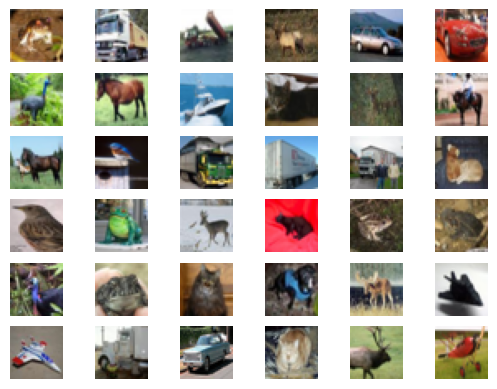

<_PrefetchDataset element_spec=TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float32, name=None)>

In [4]:
class IMAGE:

    def __init__(self):
       # loading cifar10 dataset
       (self.images, _), (_, _)=cifar10.load_data()

    def ploting_samples(self, n_samples):
          images=self.images
          # plot images from the training dataset
          for i in range(n_samples):
             # define subplot
             plt.subplot(6, 6, 1 + i)
             # turn off axis
             plt.axis('off')
             # plot raw pixel data
             plt.imshow(images[i])
          plt.show()

    def scaling(self):
         images=self.images
         # convert ints to floats
         images=images.astype('float32')
         # scaling the images from (0, 255) to range (-1, 1)
         images=(images-127.5)/127.5
         return images

    def rescaling(self):
          images=images*127.5+127.5
          return images

    def preprocessing(self, batch_size=32, drop_remainder=True, buffer_size=1):
           images=self.scaling()
           images=tf.data.Dataset.from_tensor_slices(images).shuffle(1000).batch(batch_size=batch_size, drop_remainder=drop_remainder).prefetch(buffer_size=buffer_size)
           return images

images=IMAGE()
images.ploting_samples(36)
images=images.preprocessing()
images

In [39]:
from keras.src.losses import Loss
class DCGAN:

      def __init__(self, d_optimizer=keras.optimizers.Adam(learning_rate=1e-4), g_optimizer=keras.optimizers.Adam(learning_rate=1e-4)):
         #self.discriminator=self.build_distriminator
         #self.generator=self.build_generator
         self._d_optimizer=d_optimizer
         self._g_optimizer=g_optimizer
         self.loss=keras.losses.BinaryCrossentropy()

      @property
      # getting d_optimizer
      def d_optimizer(self):
          return self._d_optimizer

      @property
      # getting g_optimizer
      def g_optimizer(self):
          return self._g_optimizer

      # setting d_optimizer
      @d_optimizer.setter
      def d_optimizer_set(self, val):
          self._d_optimizer=val
          return self._d_optimizer

       # setting d_optimizer
      @g_optimizer.setter
      def g_optimizer_set(self, val):
          self._g_optimizer=val
          return self._g_optimizer

      def d_loss(self, fake, real):
          real_loss=self.loss(tf.ones_like(real), real)
          fake_loss=self.loss(tf.ones_like(fake), fake)
          return real_loss+fake_loss

      def g_loss(self, fake):
        fake_loss=self.loss(tf.ones_like(fake), fake)
        return fake_loss

      @staticmethod
      def build_discriminator(shape=(32, 32, 3)):
          model=keras.models.Sequential(name='discriminator')
          model.add(keras.Input(shape=(32, 32, 3)))
          #model.add(keras.Input(input_shape=[32, 32, 3]))
          model.add(keras.layers.Conv2D(64, kernel_size=3, strides=3, padding='same'))
          model.add(keras.layers.BatchNormalization())
          model.add(keras.layers.LeakyReLU(alpha=0.2))
          model.add(keras.layers.Conv2D(128, kernel_size=3, strides=3, padding='same'))
          model.add(keras.layers.BatchNormalization())
          model.add(keras.layers.LeakyReLU(alpha=0.2))
          model.add(keras.layers.Conv2D(256, kernel_size=3, strides=3, padding='same'))
          model.add(keras.layers.BatchNormalization())
          model.add(keras.layers.LeakyReLU(alpha=0.2))
          model.add(keras.layers.Dropout(rate=0.2))
          model.add(keras.layers.Flatten())
          model.add(keras.layers.Dense(1, activation=keras.activations.sigmoid))
          return model

      @staticmethod
      def build_generator(latent_dim=100):
             model=keras.models.Sequential(name='generator')
             model.add(keras.layers.Dense(256*4*4, input_dim=latent_dim))
             model.add(keras.layers.LeakyReLU(alpha=0.2))
             model.add(keras.layers.Reshape((4, 4, 256)))
             # upsample to 8x8
             model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
             model.add(keras.layers.LeakyReLU(alpha=0.2))
             # upsample to 16x16
             model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
             model.add(keras.layers.LeakyReLU(alpha=0.2))
             # upsample to 32x32
             model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
             model.add(keras.layers.LeakyReLU(alpha=0.2))
             # output layer
             model.add(keras.layers.Conv2D(3, (3,3), activation='tanh', padding='same'))
             assert model.output_shape == (None, 32, 32, 3)
             return model

      @tf.function
      # this annotation compile the train_step function for better performance
      def train_step(self, images):
          # leveraging tf.GradientTape
          with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
               # we generate fake images by generator
               self.build_generator.trainable=True
               generated_images=self.build_generator(latent_dim)
               # we untying the weights of the discriminator
               self.build_discriminator.trainable=True
               # we label the images
               fake=self.build_discriminator(tf.compat.v1.convert_to_tensor(generated_images))
               real=self.build_discriminator(tf.compat.v1.convert_to_tensor(images))
               # we calcul the losses
               d_loss=self.d_loss(tf.compat.v1.convert_to_tensor(generated_images), tf.compat.v1.convert_to_tensor(images))
               g_loss=self.g_loss(tf.compat.v1.convert_to_tensor(generated_images))
               # we calcul the gradients of losses with respect to the weights
               grads_dis=d_tape.gradient(d_loss, self.discriminator.trainable_variables)
               grads_gen=g_tape.gradient(g_loss, self.generator.trainable_variables)
               # updating the weights by applying gradient algorithm with respective optimizer
               self.d_optimizer.apply(zip(grads_dis), self.discriminator.trainable_varaibles)
               self.g_optimizer.apply(zip(grads_dis), self.discriminator.trainable_varaibles)

      def fit(self, data, epochs, batch_size, latent_dim):
        # Iterate over epochs
          for epoch in tqdm.trange(epochs):
              # Iterate over a bach of images
              for images in data:
                  # we apply the train_step
                  self.train_step(images)
                  generated_images=self.build_generator(latent_dim)
                  #Iterate over generated_images
                  for i in range(generated_images.shape[0]):
                     plt.subplot(4, 4, i+1)
                     image=generated_images[i]
                     # rescaling the images
                     image=image*127.5+127.5
                     plt.imshow(image, cmap='gray')
                     plt.axis('off')
                     # save the generated images with their corresponding epochs
                     plt.savefig(f'{epoch}.png')
                     plt.show()

if __name__=='__main__':

  latent_dim=100
  batch_size=32
  epochs=10
  images=IMAGE()
  data=images.preprocessing()
  dcgan=DCGAN()
  dcgan.fit(data=data, batch_size=batch_size, epochs=epochs, latent_dim=latent_dim)



  0%|          | 0/10 [00:00<?, ?it/s]


TypeError: ignored

In [8]:
class Said(object):
  def __init__(self):
    #self.generator=self.build_generator()
    pass
  @staticmethod
  def build_generator(x):
      return x



  def train(self):
    x=0
    for i in range(10):
        x+=self.build_generator(10)
    return x

said=Said()
said.train()


100